In [259]:
import typing
from typing import Dict,TypedDict,List,Union
import langgraph
from langgraph.graph import StateGraph,START,END
from langchain_google_genai import ChatGoogleGenerativeAI
import os
from langchain_core.messages import HumanMessage,AIMessage
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage # The foundational class for all message types in LangGraph
from langchain_core.messages import ToolMessage # Passes data back to LLM after it calls a tool such as the content and the tool_call_id
from langchain_core.messages import SystemMessage # Message for providing instructions to the LLM
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END,MessagesState
from langgraph.prebuilt import ToolNode,tools_condition
import os
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
from typing import Any

In [100]:
pip install langchain-community

Note: you may need to restart the kernel to use updated packages.


<div align="center"><h2>Chatbot with basic math tools and gemini model

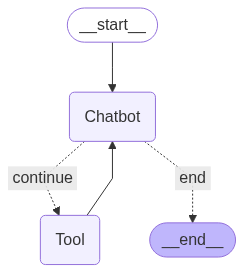

In [281]:
load_dotenv()
GOOGLE_API_KEY=os.getenv("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
model=ChatGoogleGenerativeAI(model="gemini-2.0-flash")

@tool
def multiply(a:int,b:int):
    '''Multiply a and b
    Arguments:
    a:first int
    b:second int    
    '''
    return a*b
@tool
def add(a:int,b:int):
    '''add a and b
    Arguments:
    a:first int
    b:second int    
    '''
    return a+b
@tool
def subtract(a:int,b:int):
    '''subtract a and b
    Arguments:
    a:first int
    b:second int    
    '''
    return a-b
@tool
def divide(a:int,b:int):
    '''divide a by b
    Arguments:
    a:first int
    b:second int    
    '''
    return a/b
tools=[add,subtract,divide,multiply]
model=model.bind_tools(tools)

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    
system_message = SystemMessage(content=" You are a math assistant. Always obey BODMAS rules when evaluating expressions. "
    "Use tools (add, subtract, multiply, divide) and chain them properly if needed. "
    "Perform the calculations by only using the tools and not by userself")
def chatbot(state:AgentState) -> AgentState:
    response=model.invoke([system_message]+state["messages"])
    return({"messages":[response]})

def should_continue(state: AgentState): 
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls: 
        return "end"
    else:
        return "continue"
    
graph=StateGraph(MessagesState)
graph.add_node("Chatbot",chatbot)
tool_node=ToolNode(tools=tools)
graph.add_node("Tool",tool_node)
graph.add_edge(START,"Chatbot")
graph.add_conditional_edges("Chatbot",should_continue, {
        "continue": "Tool",  
        "end": END
    })
graph.add_edge("Tool","Chatbot")

app=graph.compile()
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
user_input=input("Enter: ")
messages=[HumanMessage(content=user_input)]
result_1=app.invoke({"messages":messages})
# for m in result_1["messages"]:
#     m.pretty_print()
print(result_1["messages"][-1].content)

<div align="center"><h2>Model wih weather API and can also counterquestion the user in case of any doubts


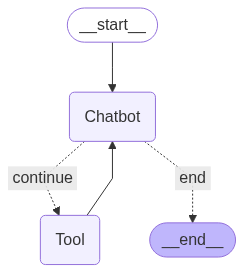

In [282]:
load_dotenv()
GOOGLE_API_KEY=os.getenv("GOOGLE_API_KEY")
OPENWEATHERMAP_API_KEY=os.getenv("OPENWEATHERMAP_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["OPENWEATHERMAP_API_KEY"]=OPENWEATHERMAP_API_KEY
model_2=ChatGoogleGenerativeAI(model="gemini-2.0-flash")

from langchain_community.utilities import OpenWeatherMapAPIWrapper
weather = OpenWeatherMapAPIWrapper()

@tool
def multiply(a:int,b:int):
    '''Multiply a and b
    Arguments:
    a:first int
    b:second int    
    '''
    return a*b
@tool
def add(a:int,b:int):
    '''add a and b
    Arguments:
    a:first int
    b:second int    
    '''
    return a+b
@tool
def subtract(a:int,b:int):
    '''subtract a and b
    Arguments:
    a:first int
    b:second int    
    '''
    return a-b
@tool
def divide(a:int,b:int):
    '''divide a by b
    Arguments:
    a:first int
    b:second int    
    '''
    return a/b
@tool
def user_input(query: str) -> str:
    """Gets user input based on the provided query."""
    user_input = input(query + ": ")
    return user_input
    
tools=[add,subtract,divide,multiply,weather.run,user_input]
model_2=model_2.bind_tools(tools)

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    
system_message = SystemMessage(content=" You are my AI assistant, please answer my query to the best of your ability."
    "You can can as a math assistant"
    "Always obey BODMAS rules when evaluating expressions."
    "Use tools (add, subtract, multiply, divide) and chain them properly if needed. "
    "Perform the calculations by only using the tools and not by userself"
    "You are also a very helpful assistant that provides weather information using weather tool."
    "For any question related to weather — including current weather, temperature, humidity, wind, forecast, or conditions — always use the weather tool and never reject or make the data yourself.Always call the weather tool."
    "If the user does not specify the location, ask for one using input_data tool . If the user asks for weather at a specific time or date, include that also in the input_data tool."
    "If you fell the user has made some incomplete request and you need input always use user_input tool"
)
def chatbot(state:AgentState) -> AgentState:
    response=model_2.invoke([system_message]+state["messages"])
    return({"messages":[response]})

def should_continue(state: AgentState): 
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls: 
        return "end"
    else:
        return "continue"
    
graph=StateGraph(MessagesState)
graph.add_node("Chatbot",chatbot)
tool_node=ToolNode(tools=tools)
graph.add_node("Tool",tool_node)
graph.add_edge(START,"Chatbot")
graph.add_conditional_edges("Chatbot",should_continue, {
        "continue": "Tool",  
        "end": END
    })
graph.add_edge("Tool","Chatbot")

app=graph.compile()
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

<h3>Interaction

In [285]:

user_input=input("Heyyyyyyy: ")
while(user_input.lower() not in ["quit","exit","bye"]):
    messages=[HumanMessage(content=user_input)]
    result_1=app.invoke({"messages":messages})
    print(result_1["messages"][-1].content)
    user_input=input("Heyyyyy: ")


OK. The weather in Faridkot is clear with a wind speed of 4.07 m/s from 128 degrees. The humidity is 40%. The temperature is 29.97°C, but it feels like 29.65°C. There is no rain and the cloud cover is 0%.


<h3>after asking what is the weather the model counterquestioned to specify the location


In [288]:
user_input=input("Heyyyyyyy: ")
while(user_input.lower() not in ["quit","exit","bye"]):
    messages=[HumanMessage(content=user_input)]
    result_1=app.invoke({"messages":messages})
    for m in result_1["messages"]:
        m.pretty_print()
    user_input=input("Heyyyyy: ")

================================ Human Message =================================

what is weather
================================== Ai Message ==================================
Tool Calls:
  user_input (4793e01d-02ca-44b5-9338-cc4e20fda134)
 Call ID: 4793e01d-02ca-44b5-9338-cc4e20fda134
  Args:
    query: Could you please specify the location for which you want weather information?
================================= Tool Message =================================
Name: user_input

faridkot
================================== Ai Message ==================================
Tool Calls:
  run (910afc6e-63be-4f7d-a360-4376eca571af)
 Call ID: 910afc6e-63be-4f7d-a360-4376eca571af
  Args:
    location: faridkot
================================= Tool Message =================================
Name: run

In faridkot, the current weather is as follows:
Detailed status: clear sky
Wind speed: 4.07 m/s, direction: 128°
Humidity: 40%
Temperature: 
  - Current: 29.97°C
  - High: 29.97°C
  - Low: 29.97°C


In [262]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langgraph.prebuilt import ToolNode
load_dotenv()
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
os.environ["TAVILY_API_KEY"]=TAVILY_API_KEY
search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)

<div align="center"><h2>Model with Web_search included and capable of counterquestioning

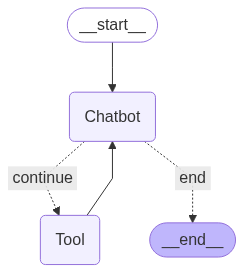

In [289]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langgraph.prebuilt import ToolNode

load_dotenv()
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
os.environ["TAVILY_API_KEY"]=TAVILY_API_KEY
search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)

GOOGLE_API_KEY=os.getenv("GOOGLE_API_KEY")
OPENWEATHERMAP_API_KEY=os.getenv("OPENWEATHERMAP_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["OPENWEATHERMAP_API_KEY"]=OPENWEATHERMAP_API_KEY
model_3=ChatGoogleGenerativeAI(model="gemini-2.0-flash")

from langchain_community.utilities import OpenWeatherMapAPIWrapper
weather = OpenWeatherMapAPIWrapper()

@tool
def multiply(a:int,b:int):
    '''Multiply a and b
    Arguments:
    a:first int
    b:second int    
    '''
    return a*b
@tool
def add(a:int,b:int):
    '''add a and b
    Arguments:
    a:first int
    b:second int    
    '''
    return a+b
@tool
def subtract(a:int,b:int):
    '''subtract a and b
    Arguments:
    a:first int
    b:second int    
    '''
    return a-b
@tool
def divide(a:int,b:int):
    '''divide a by b
    Arguments:
    a:first int
    b:second int    
    '''
    return a/b
@tool
def user_input(query: str) -> str:
    """Gets user input based on the provided query."""
    user_input = input(query + ": ")
    return user_input
    
tools=[add,subtract,divide,multiply,weather.run,user_input,tavily_tool]
model_3=model_3.bind_tools(tools)

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    
system_message = SystemMessage(content=" You are my AI assistant, please answer my query to the best of your ability."
    "You can can as a math assistant"
    "Always obey BODMAS rules when evaluating expressions."
    "Use tools (add, subtract, multiply, divide) and chain them properly if needed. "
    "Perform the calculations by only using the tools and not by userself"
    "You are also a very helpful assistant that provides weather information using weather tool."
    "For any question related to weather — including current weather, temperature, humidity, wind, forecast, or conditions — always use the weather tool and never reject or make the data yourself.Always call the weather tool."
    "If the user does not specify the location, ask for one using input_data tool . If the user asks for weather at a specific time or date, include that also in the input_data tool."
    "If you fell the user has made some incomplete request and you need input always use user_input tool"
    "You can also do web search using tavily_tool."
    "If the user input needs you to search the web always do web search using tavily_tool and not make answers by yourself."
    "Ask the user again how many results to give using user_input tool and according to the answer of user give that results out of the dictionary returned by tavily_tool."
    "If you are displaying multiple results as given by user always print the number of result and then display its content"
    "Only display the content of each result in not more than 100 words by summarising the result"
)
def chatbot(state:AgentState) -> AgentState:
    response=model_3.invoke([system_message]+state["messages"])
    return({"messages":[response]})

def should_continue(state: AgentState): 
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls: 
        return "end"
    else:
        return "continue"
    
graph=StateGraph(MessagesState)
graph.add_node("Chatbot",chatbot)
tool_node=ToolNode(tools=tools)
graph.add_node("Tool",tool_node)
graph.add_edge(START,"Chatbot")
graph.add_conditional_edges("Chatbot",should_continue, {
        "continue": "Tool",  
        "end": END
    })
graph.add_edge("Tool","Chatbot")

app=graph.compile()
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

<h2>Interactions

In [ ]:
user_input=input("Heyyyyyyy: ")
while(user_input.lower() not in ["quit","exit","bye"]):
    messages=[HumanMessage(content=user_input)]
    result_1=app.invoke({"messages":messages})
    print(result_1["messages"][-1].content)
    user_input=input("Heyyyyy: ")

Here are the latest trends in London, based on the search results:

1.  **London Fashion Trends 2025:** Animal print jackets (especially leopard print) are expected to be popular in 2025. Also, keep an eye out for cardigans with contrast buttons.
2.  **What to wear in London: the ultimate style guide:** London style is experimental, mixing prints and colors with classic looks. Layering necklaces are a dominant jewelry trend.
3.  **The 8 Items That Defined London Street Style In 2024 | British Vogue:** Baggy jeans, track jackets, and suede bags.
Okay, I will share 3 results.

Result 1: The Simple White Cake Recipe from Allrecipes includes creaming sugar and butter, adding eggs and vanilla, combining flour and baking powder, and then adding milk. The batter is baked at 350 degrees F (175 degrees C) for 30-40 minutes.

Result 2: The Easy Birthday Cake Recipe From Scratch from Southern Plate involves creaming sugar and softened butter, mixing flour, baking powder, and salt separately, and 

In [ ]:
user_input=input("Heyyyyy: ")
events = app.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi what is the weather
================================== Ai Message ==================================
Tool Calls:
  user_input (45741b8d-e45a-4a27-ba87-c50ebe157912)
 Call ID: 45741b8d-e45a-4a27-ba87-c50ebe157912
  Args:
    query: Could you please specify the location for which you want weather information?
================================= Tool Message =================================
Name: user_input

Farid
================================== Ai Message ==================================
Tool Calls:
  run (d4701317-94b9-4c8a-9483-b73fc6d1fbb6)
 Call ID: d4701317-94b9-4c8a-9483-b73fc6d1fbb6
  Args:
    location: Farid
================================= Tool Message =================================
Name: run

Error: NotFoundError('Unable to find the resource')
 Please fix your mistakes.
================================== Ai Message ==================================
Tool Calls:
  user_input (26145849-1

<div align="center"><h2>Model with Memory included and capable of counterquestioning

In [265]:
from langgraph.checkpoint.memory import InMemorySaver
checkpointer = InMemorySaver()

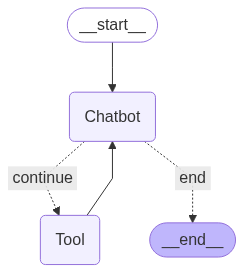

In [266]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langgraph.prebuilt import ToolNode
checkpointer = InMemorySaver()

load_dotenv()
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
os.environ["TAVILY_API_KEY"]=TAVILY_API_KEY
search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)

GOOGLE_API_KEY=os.getenv("GOOGLE_API_KEY")
OPENWEATHERMAP_API_KEY=os.getenv("OPENWEATHERMAP_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["OPENWEATHERMAP_API_KEY"]=OPENWEATHERMAP_API_KEY
model_4=ChatGoogleGenerativeAI(model="gemini-2.0-flash")

from langchain_community.utilities import OpenWeatherMapAPIWrapper
weather = OpenWeatherMapAPIWrapper()

@tool
def multiply(a:int,b:int):
    '''Multiply a and b
    Arguments:
    a:first int
    b:second int    
    '''
    return a*b
@tool
def add(a:int,b:int):
    '''add a and b
    Arguments:
    a:first int
    b:second int    
    '''
    return a+b
@tool
def subtract(a:int,b:int):
    '''subtract a and b
    Arguments:
    a:first int
    b:second int    
    '''
    return a-b
@tool
def divide(a:int,b:int):
    '''divide a by b
    Arguments:
    a:first int
    b:second int    
    '''
    return a/b
@tool
def user_input(query: str) -> str:
    """Gets user input based on the provided query."""
    user_input = input(query + ": ")
    return user_input
    
tools=[add,subtract,divide,multiply,weather.run,user_input,tavily_tool]
model_4=model_4.bind_tools(tools)

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    
system_message = SystemMessage(content=" You are my AI assistant, please answer my query to the best of your ability."
                               "You have access to many tools always use the tools stepwise.Properly display the results from each tool"
    "You can can as a math assistant"
    "Always obey BODMAS rules when evaluating expressions."
    "Use tools (add, subtract, multiply, divide) and chain them properly if needed. "
    "Perform the calculations by only using the tools and not by userself"
    "You are also a very helpful assistant that provides weather information using weather tool."
    "For any question related to weather — including current weather, temperature, humidity, wind, forecast, or conditions — always use the weather tool and never reject or make the data yourself.Always call the weather tool."
    "If the user does not specify the location, ask for one using input_data tool . If the user asks for weather at a specific time or date, include that also in the input_data tool."
    "If you fell the user has made some incomplete request and you need input always use user_input tool"
    "You can also do web search using tavily_tool.Always ask the user again how many results to give using user_input tool and according to the answer of user give that results out of the dictionary returned by tavily_tool."
    "If the user input needs you to search the web always do web search using tavily_tool and not make answers by yourself."
    "Ask the user again how many results to give using user_input tool and according to the answer of user give that results out of the dictionary returned by tavily_tool."
    "If you are displaying multiple results as given by user always print the number of result and then display its content"
    "Only display the content of each result in not more than 100 words by summarising the result"
    "Always ask follow up questions from user using user_input tool is it is needed"
)
def chatbot(state:AgentState) -> AgentState:
    response=model_4.invoke([system_message]+state["messages"])
    return({"messages":[response]})

def should_continue(state: AgentState): 
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls: 
        return "end"
    else:
        return "continue"
    
graph=StateGraph(MessagesState)
graph.add_node("Chatbot",chatbot)
tool_node=ToolNode(tools=tools)
graph.add_node("Tool",tool_node)
graph.add_edge(START,"Chatbot")
graph.add_conditional_edges("Chatbot",should_continue, {
        "continue": "Tool",  
        "end": END
    })
graph.add_edge("Tool","Chatbot")

app=graph.compile(checkpointer=checkpointer)
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

Interaction

In [ ]:
config={"configurable": {"thread_id": "1"}}
user_input=input("Heyyyyy: ")
events = app.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi my name is ayush .can you tell what is the weather in Chandigarh.After that tell latest fashion trends in delhi
================================== Ai Message ==================================
Tool Calls:
  run (ff5a96f3-1c18-4978-b45d-f30842288b2e)
 Call ID: ff5a96f3-1c18-4978-b45d-f30842288b2e
  Args:
    location: Chandigarh
  user_input (1590ccc1-f5e6-462d-9509-3e6db78d6c24)
 Call ID: 1590ccc1-f5e6-462d-9509-3e6db78d6c24
  Args:
    query: How many search results do you want for the latest fashion trends in Delhi?
================================= Tool Message =================================
Name: user_input

2
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (67c655f7-9978-4789-9bae-7515626cecce)
 Call ID: 67c655f7-9978-4789-9bae-7515626cecce
  Args:
    query: latest fashion trends in Delhi
================================

In [ ]:
config={"configurable": {"thread_id": "1"}}
user_input=input("Heyyyyy: ")
events = app.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi what is my name and what city weather i asked use now and what city trends i ask for
================================== Ai Message ==================================

Okay, here's a summary of what I remember:

*   **Your name:** Ayush
*   **City weather you asked about now:** Chandigarh
*   **City fashion trends you asked about:** Delhi


In [ ]:
config={"configurable": {"thread_id": "1"}}
user_input=input("Heyyyyy: ")
events = app.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

tell what was the latest question i asked from you
================================== Ai Message ==================================

The latest question you asked me was: "tell what was the latest question i asked from you".


In [ ]:
config={"configurable": {"thread_id": "1"}}
user_input=input("Heyyyyy: ")
events = app.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Dont be oversmart tell me which the latest message before this one
================================== Ai Message ==================================

The latest message before this one was: "tell what was the latest question i asked from you".


In [ ]:
pip install langmem

   ---------------------------------------- 0.0/720.4 kB ? eta -:--:--
   -------------- ------------------------- 262.1/720.4 kB ? eta -:--:--
   ---------------------------------------- 720.4/720.4 kB 1.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/894.9 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/894.9 kB ? eta -:--:--
   ---------------------------------------- 894.9/894.9 kB 2.5 MB/s eta 0:00:00

   ------------ ---------------------------  3/10 [openai]
   ------------ ---------------------------  3/10 [openai]
   ------------ ---------------------------  3/10 [openai]
   ------------ ---------------------------  3/10 [openai]
   ------------ ---------------------------  3/10 [openai]
   ------------ ---------------------------  3/10 [openai]
   -------------------- -------------------  5/10 [anthropic]
   -------------------- -------------------  5/10 [anthropic]
   -------------------- -------------------  5/10 [anthropic]
   --------

<div align="center"><h2>Also Memory model

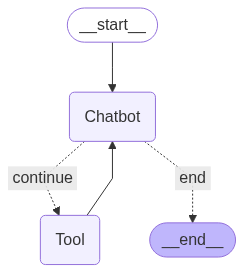

In [267]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langgraph.prebuilt import ToolNode
checkpointer = InMemorySaver()

load_dotenv()
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
os.environ["TAVILY_API_KEY"]=TAVILY_API_KEY
search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)

GOOGLE_API_KEY=os.getenv("GOOGLE_API_KEY")
OPENWEATHERMAP_API_KEY=os.getenv("OPENWEATHERMAP_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["OPENWEATHERMAP_API_KEY"]=OPENWEATHERMAP_API_KEY
model_4=ChatGoogleGenerativeAI(model="gemini-2.0-flash")

from langchain_community.utilities import OpenWeatherMapAPIWrapper
weather = OpenWeatherMapAPIWrapper()

@tool
def multiply(a:int,b:int):
    '''Multiply a and b
    Arguments:
    a:first int
    b:second int    
    '''
    return a*b
@tool
def add(a:int,b:int):
    '''add a and b
    Arguments:
    a:first int
    b:second int    
    '''
    return a+b
@tool
def subtract(a:int,b:int):
    '''subtract a and b
    Arguments:
    a:first int
    b:second int    
    '''
    return a-b
@tool
def divide(a:int,b:int):
    '''divide a by b
    Arguments:
    a:first int
    b:second int    
    '''
    return a/b
@tool
def user_input(query: str) -> str:
    """Gets user input based on the provided query."""
    user_input = input(query + ": ")
    return user_input
    
tools=[add,subtract,divide,multiply,weather.run,user_input,tavily_tool]
model_4=model_4.bind_tools(tools)

# class AgentState(TypedDict):
#     messages: Annotated[Sequence[BaseMessage], add_messages]
    
system_message = SystemMessage(content=" You are my AI assistant, please answer my query to the best of your ability."
                               "You have access to many tools always use the tools stepwise.Properly display the results from each tool"
    "You can can as a math assistant"
    "Always obey BODMAS rules when evaluating expressions."
    "Use tools (add, subtract, multiply, divide) and chain them properly if needed. "
    "Perform the calculations by only using the tools and not by userself"
    "You are also a very helpful assistant that provides weather information using weather tool."
    "For any question related to weather — including current weather, temperature, humidity, wind, forecast, or conditions — always use the weather tool and never reject or make the data yourself.Always call the weather tool."
    "If the user does not specify the location, ask for one using input_data tool . If the user asks for weather at a specific time or date, include that also in the input_data tool."
    "If you fell the user has made some incomplete request and you need input always use user_input tool"
    "You can also do web search using tavily_tool.Always ask the user again how many results to give using user_input tool and according to the answer of user give that results out of the dictionary returned by tavily_tool."
    "If the user input needs you to search the web always do web search using tavily_tool and not make answers by yourself."
    "Ask the user again how many results to give using user_input tool and according to the answer of user give that results out of the dictionary returned by tavily_tool."
    "If you are displaying multiple results as given by user always print the number of result and then display its content"
    "Only display the content of each result in not more than 100 words by summarising the result"
    "Always ask follow up questions from user using user_input tool is it is needed"
)
def chatbot(state:MessagesState) -> MessagesState:
    response=model_4.invoke([system_message]+state["messages"])
    return({"messages":[response]})

def should_continue(state: AgentState): 
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls: 
        return "end"
    else:
        return "continue"
    
graph=StateGraph(MessagesState)
graph.add_node("Chatbot",chatbot)
tool_node=ToolNode(tools=tools)
graph.add_node("Tool",tool_node)
graph.add_edge(START,"Chatbot")
graph.add_conditional_edges("Chatbot",should_continue, {
        "continue": "Tool",  
        "end": END
    })
graph.add_edge("Tool","Chatbot")

app=graph.compile(checkpointer=checkpointer)
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
config={"configurable": {"thread_id": "1"}}
user_input=input("Heyyyyy: ")
events = app.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi tell the weather in faridkot .also tell latest current affairs
================================== Ai Message ==================================
Tool Calls:
  run (a67c8997-0a00-46a9-901e-34283da692c0)
 Call ID: a67c8997-0a00-46a9-901e-34283da692c0
  Args:
    location: faridkot
================================= Tool Message =================================
Name: run

In faridkot, the current weather is as follows:
Detailed status: few clouds
Wind speed: 3.99 m/s, direction: 86°
Humidity: 24%
Temperature: 
  - Current: 38.58°C
  - High: 38.58°C
  - Low: 38.58°C
  - Feels like: 38.49°C
Rain: {}
Heat index: None
Cloud cover: 16%
================================== Ai Message ==================================

OK. The current weather in Faridkot is: few clouds, wind speed 3.99 m/s from 86 degrees, humidity 24%, and a temperature of 38.58°C (feels like 38.49°C).

To provide you with the latest current affa

<div align="center"><h2>Memory model with memory summarization

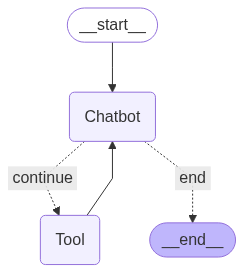

In [278]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langgraph.prebuilt import ToolNode
from langmem.short_term import SummarizationNode
from langchain_core.messages.utils import count_tokens_approximately
from langgraph.checkpoint.memory import InMemorySaver
checkpointer = InMemorySaver()

load_dotenv()
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
os.environ["TAVILY_API_KEY"]=TAVILY_API_KEY
search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)

GOOGLE_API_KEY=os.getenv("GOOGLE_API_KEY")
OPENWEATHERMAP_API_KEY=os.getenv("OPENWEATHERMAP_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["OPENWEATHERMAP_API_KEY"]=OPENWEATHERMAP_API_KEY
model_5=ChatGoogleGenerativeAI(model="gemini-2.0-flash")

from langchain_community.utilities import OpenWeatherMapAPIWrapper
weather = OpenWeatherMapAPIWrapper()

@tool
def multiply(a:int,b:int):
    '''Multiply a and b
    Arguments:
    a:first int
    b:second int    
    '''
    return a*b
@tool
def add(a:int,b:int):
    '''add a and b
    Arguments:
    a:first int
    b:second int    
    '''
    return a+b
@tool
def subtract(a:int,b:int):
    '''subtract a and b
    Arguments:
    a:first int
    b:second int    
    '''
    return a-b
@tool
def divide(a:int,b:int):
    '''divide a by b
    Arguments:
    a:first int
    b:second int    
    '''
    return a/b
@tool
def user_input(query: str) -> str:
    """Gets user input based on the provided query."""
    user_input = input(query + ": ")
    return user_input
    
tools=[add,subtract,divide,multiply,weather.run,user_input,tavily_tool]
model_5=model_5.bind_tools(tools)

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    
system_message = SystemMessage(content=" You are my AI assistant, please answer my query to the best of your ability."
                               "You have access to many tools always use the tools stepwise.Properly display the results from each tool"
                               "Never forget to call user_input tool after asking for some input"
    "You can can as a math assistant"
    "Always obey BODMAS rules when evaluating expressions."
    "Use tools (add, subtract, multiply, divide) and chain them properly if needed. "
    "Perform the calculations by only using the tools and not by userself"
    "You are also a very helpful assistant that provides weather information using weather tool."
    "For any question related to weather — including current weather, temperature, humidity, wind, forecast, or conditions — always use the weather tool and never reject or make the data yourself.Always call the weather tool."
    "If the user does not specify the location, ask for one using input_data tool . If the user asks for weather at a specific time or date, include that also in the input_data tool."
    "If you fell the user has made some incomplete request and you need input always use user_input tool"
    "You can also do web search using tavily_tool.Always ask the user again how many results to give using user_input tool and according to the answer of user give that results out of the dictionary returned by tavily_tool."
    "If the user input needs you to search the web always do web search using tavily_tool and not make answers by yourself."
    "Ask the user again how many results to give using user_input tool and according to the answer of user give that results out of the dictionary returned by tavily_tool."
    "If you are displaying multiple results as given by user always print the number of result and then display its content"
    "Only display the content of each result in not more than 100 words by summarising the result"
    "Always ask follow up questions from user using user_input tool is it is needed"
    "At the end always ask user 'Can I hellp you with something else?' and call user_input tool.Never forget to call user_input tool after asking for some input.If the user says 'no','bye' or something similar then end"
)
def chatbot(state:AgentState) -> AgentState:
    response=model_5.invoke([system_message]+state["messages"])
    return({"messages":[response]})

def should_continue(state: AgentState): 
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls: 
        return "end"
    else:
        return "continue"
summarization_node = SummarizationNode( 


    token_counter=count_tokens_approximately,
    model=model_5,
    max_tokens=384,
    max_summary_tokens=128,
    output_messages_key="llm_input_messages",
)
class State(AgentState):
    context: dict[str, Any]    
graph=StateGraph(State)
graph.add_node("Chatbot",chatbot)
tool_node=ToolNode(tools=tools)
graph.add_node("Tool",tool_node)
graph.add_edge(START,"Chatbot")
graph.add_conditional_edges("Chatbot",should_continue, {
        "continue": "Tool",  
        "end": END
    })
graph.add_edge("Tool","Chatbot")

app=graph.compile(checkpointer=checkpointer)
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

<h2>Interactions

In [ ]:
config={"configurable": {"thread_id": "1"}}
user_input=input("Heyyyyy: ")
events = app.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

hi do you know my name
================================== Ai Message ==================================
Tool Calls:
  user_input (eedc5dcf-0f36-4258-b9a1-6139e8ac0559)
 Call ID: eedc5dcf-0f36-4258-b9a1-6139e8ac0559
  Args:
    query: As a large language model, I do not have memory of past conversations. What is your name?
================================= Tool Message =================================
Name: user_input

Ayush
================================== Ai Message ==================================

Hello Ayush, nice to meet you! Can I help you with something else?
Tool Calls:
  user_input (a56caa14-a539-40d7-97be-44546a739aa6)
 Call ID: a56caa14-a539-40d7-97be-44546a739aa6
  Args:
    query: Can I help you with something else?
================================= Tool Message =================================
Name: user_input

tell a joke
================================== Ai Message =================

In [ ]:
config={"configurable": {"thread_id": "1"}}
user_input=input("Heyyyyy: ")
events = app.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is my name
================================== Ai Message ==================================

I learned your name in our previous interaction. Your name is Ayush. Can I help you with something else?
Tool Calls:
  user_input (faf63504-d43b-4e75-9855-150f025cde86)
 Call ID: faf63504-d43b-4e75-9855-150f025cde86
  Args:
    query: Can I help you with something else?
================================= Tool Message =================================
Name: user_input

tell what was the question i asked from you in our previos interaction
================================== Ai Message ==================================

You asked me if I knew your name.
Tool Calls:
  user_input (5aa8e544-13fa-4c69-9d8a-d12ea4fdda77)
 Call ID: 5aa8e544-13fa-4c69-9d8a-d12ea4fdda77
  Args:
    query: Can I help you with something else?
================================= Tool Message =================================
Name: user_input

In [ ]:
config={"configurable": {"thread_id": "1"}}
user_input=input("Heyyyyy: ")
events = app.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

hi
================================== Ai Message ==================================

Hi there! How can I help you today?
Tool Calls:
  user_input (b4664dd4-bc6a-4b98-9de1-e89ac16c0aed)
 Call ID: b4664dd4-bc6a-4b98-9de1-e89ac16c0aed
  Args:
    query: How can I help you today?
================================= Tool Message =================================
Name: user_input

no
================================== Ai Message ==================================

Ok, bye.


In [ ]:
config={"configurable": {"thread_id": "1"}}
user_input=input("Heyyyyy: ")
events = app.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi lets play a game
================================== Ai Message ==================================
Tool Calls:
  user_input (5e2655f7-c28f-4a64-bf1d-90db4655b153)
 Call ID: 5e2655f7-c28f-4a64-bf1d-90db4655b153
  Args:
    query: What game would you like to play?
================================= Tool Message =================================
Name: user_input

i will think a number and you will guess
================================== Ai Message ==================================

Okay, I'm ready. Is there a range for the number I need to guess?
Tool Calls:
  user_input (beb93efe-6cb0-4a31-8782-7a8396233bc0)
 Call ID: beb93efe-6cb0-4a31-8782-7a8396233bc0
  Args:
    query: What is the range of the number you are thinking of? For example, is it between 1 and 10?
================================= Tool Message =================================
Name: user_input

yes
================================== Ai Mess

In [56]:
config={"configurable": {"thread_id": "1"}}
user_input=input("Heyyyyy: ")
events = app.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is the weather in Faridkot and Delhi
================================== Ai Message ==================================
Tool Calls:
  run (1b407a3d-2e8e-42d0-857f-d193b65348b6)
 Call ID: 1b407a3d-2e8e-42d0-857f-d193b65348b6
  Args:
    location: Faridkot
  run (d38002ff-7c3c-4b2c-97ac-b6212a788663)
 Call ID: d38002ff-7c3c-4b2c-97ac-b6212a788663
  Args:
    location: Delhi
================================= Tool Message =================================
Name: run

In Delhi, the current weather is as follows:
Detailed status: haze
Wind speed: 3.09 m/s, direction: 70°
Humidity: 62%
Temperature: 
  - Current: 30.05°C
  - High: 30.05°C
  - Low: 30.05°C
  - Feels like: 33.34°C
Rain: {}
Heat index: None
Cloud cover: 20%
================================== Ai Message ==================================

The weather in Faridkot is clear with a temperature of 39.85°C, wind speed of 2.21 m/s, and humidity of 18%. Th

In [279]:
config={"configurable": {"thread_id": "1"}}
user_input=input("Heyyyyy: ")
events = app.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hi there! How can I help you today?
Tool Calls:
  user_input (6c075513-dc29-409a-b4c3-492479332be6)
 Call ID: 6c075513-dc29-409a-b4c3-492479332be6
  Args:
    query: How can I help you today?
================================= Tool Message =================================
Name: user_input

tell weather in mohali and latest news in mohali
================================== Ai Message ==================================
Tool Calls:
  run (3b521241-d0cb-451c-beda-e968342f049b)
 Call ID: 3b521241-d0cb-451c-beda-e968342f049b
  Args:
    location: mohali
================================= Tool Message =================================
Name: run

In mohali, the current weather is as follows:
Detailed status: clear sky
Wind speed: 1.57 m/s, direction: 130°
Humidity: 43%
Temperature: 
  - Current: 29.28°C
  - High: 29.28°C
  - Low: 

<div align="center"><h2>Multi Agent</h2></div>

<div align="center">
  <h2><b>Tools</b></h2>
</div>

In [221]:

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langgraph.prebuilt import ToolNode
load_dotenv()
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
os.environ["TAVILY_API_KEY"]=TAVILY_API_KEY
search = TavilySearchAPIWrapper()
web_search = TavilySearchResults(api_wrapper=search, max_results=5)

from langchain_community.utilities import OpenWeatherMapAPIWrapper
weather_api = OpenWeatherMapAPIWrapper()


@tool
def weather(location: str) -> str:
    """Returns the current weather for a given location."""
    return weather_api.run(location)
@tool
def multiply(a:int,b:int):
    '''Multiply a and b
    Arguments:
    a:first int
    b:second int    
    '''
    return a*b
@tool
def add(a:int,b:int):
    '''add a and b
    Arguments:
    a:first int
    b:second int    
    '''
    return a+b
@tool
def subtract(a:int,b:int):
    '''subtract a and b
    Arguments:
    a:first int
    b:second int    
    '''
    return a-b
@tool
def divide(a:int,b:int):
    '''divide a by b
    Arguments:
    a:first int
    b:second int    
    '''
    return a/b
@tool
def user_input(query: str) -> str:
    """Gets user input based on the provided query."""
    user_input = input(query + ": ")
    return user_input

# class AgentState(TypedDict):
#     messages: Annotated[Sequence[BaseMessage], add_messages]

Creating printing function

In [ ]:
# hide-cell
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

<div align="center">
  <h2><b>Research Agent</b></h2>
</div>

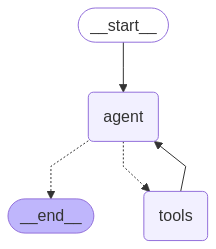

In [244]:
from langgraph.prebuilt import create_react_agent

research_agent = create_react_agent(
    model=ChatGoogleGenerativeAI(model="gemini-2.5-flash-preview-05-20"),
    tools=[web_search],
    prompt=(
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, DO NOT do any math or any answer by yourself perform only web search tasks using web search tool\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
        "After completing the task always respond back to the supervisor directly\n"
    ),
    name="research_agent",
)
from IPython.display import Image, display
display(Image(research_agent.get_graph().draw_mermaid_png()))

<div align="center"><h2>Math Agent</h2></div>

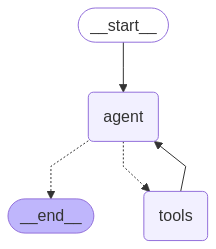

In [245]:
math_agent = create_react_agent(
    model=ChatGoogleGenerativeAI(model="gemini-2.5-flash-preview-05-20"),
    tools=[add, multiply, divide,subtract],
    prompt=(
        "You are a math agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with math-related tasks\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
        "After completing the task always respond back to the supervisor directly\n"
    ),
    name="math_agent",
)
from IPython.display import Image, display
display(Image(research_agent.get_graph().draw_mermaid_png()))

<div align="center"><h2>Weather Agent</h2></div>

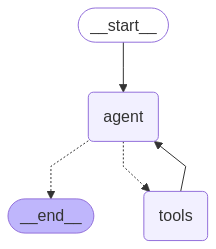

In [246]:
weather_agent =create_react_agent(
    model=ChatGoogleGenerativeAI(model="gemini-2.5-flash-preview-05-20"),
    tools=[weather],
    prompt=(
        "You are a weather agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with weather information using weather tool\n"
        "You are also a very helpful assistant that provides weather information using weather tool."
        "For any question related to weather — including current weather, temperature, humidity, wind, forecast, or conditions — always use the weather tool and never reject or make the data yourself.Always call the weather tool."
        # "If the user does not specify the location, ask for one using input_data tool . If the user asks for weather at a specific time or date, include that also in the input_data tool."
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
        "After completing the task always respond back to the supervisor directly\n"
    ),
    name="weather_agent",
)
from IPython.display import Image, display
display(Image(weather_agent.get_graph().draw_mermaid_png()))

<div align="center"><h2>Make handoff Tools</h2></div>


In [ ]:
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.prebuilt import InjectedState
from langgraph.types import Command
from langgraph.types import Send


def create_handoff_tool(*, agent_name: str, description: str | None = None):
    name = f"transfer_to_{agent_name}"
    description = description or f"Ask {agent_name} for help."

    @tool(name, description=description)
    def handoff_tool(
        state: Annotated[MessagesState, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ) -> Command:
        tool_message = {
            "role": "tool",
            "content": f"Successfully transferred to {agent_name}",
            "name": name,
            "tool_call_id": tool_call_id,
        }
        
        return Command(
            
            goto=agent_name,  
            
            update={**state, "messages": state["messages"] + [tool_message]},  # (2)!
            
            graph=Command.PARENT, 
        )

    return handoff_tool
# def create_handoff_tool(
#     *, agent_name: str, description: str | None = None
# ):
#     name = f"transfer_to_{agent_name}"
#     description = description or f"Ask {agent_name} for help."

#     @tool(name, description=description)
#     def handoff_tool(
#         # this is populated by the supervisor LLM
#         task_description: Annotated[
#             str,
#             "Description of what the next agent should do, including all of the relevant context.",
#         ],
#         # these parameters are ignored by the LLM
#         state: Annotated[MessagesState, InjectedState],
#     ) -> Command:
#         task_description_message = {"role": "user", "content": task_description}
#         agent_input = {**state, "messages": [task_description_message]}
#         return Command(
#             # highlight-next-line
#             goto=[Send(agent_name, agent_input)],
#             graph=Command.PARENT,
#         )

#     return handoff_tool



# Handoffs
assign_to_research_agent = create_handoff_tool(
    agent_name="research_agent",
    description="Assign task to a researcher agent.",
)

assign_to_math_agent = create_handoff_tool(
    agent_name="math_agent",
    description="Assign task to a math agent.",
)
assign_to_weather_agent = create_handoff_tool(
    agent_name="weather_agent",
    description="Assign task to a weather agent.",
)

<div align="center"><h2>Create Supervisor</h2></div>

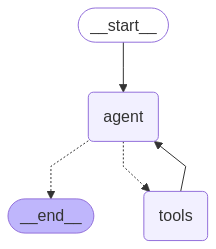

In [255]:
supervisor_agent = create_react_agent(
    model=ChatGoogleGenerativeAI(model="gemini-2.5-flash-preview-05-20"),
    tools=[assign_to_research_agent, assign_to_math_agent,assign_to_weather_agent],
    prompt=("You do not give any output to user, just give commands to call Your three agents:\n"
       "You are a supervisor managing three agents:\n"
        "- a research agent. Assign research-related tasks to this assistant\n"
        "- a math agent. Assign math-related tasks to this assistant\n"
        "-a weather agent. Assign weather-related tasks to this assistant.For any question related to weather — including current weather, temperature, humidity, wind, forecast, or conditions — always use the weather tool and never reject or make the data yourself\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
        "You do not print anything"
    
    ),
    name="supervisor"
)
from IPython.display import Image, display
display(Image(supervisor_agent.get_graph().draw_mermaid_png()))


<div align="center"><h2>Creating the Multi Agentic Graph</h2></div>

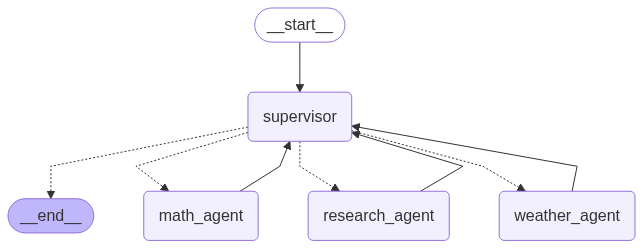

In [256]:
from langgraph.graph import END

# Define the multi-agent supervisor graph
supervisor = (
    StateGraph(MessagesState)
    # NOTE: `destinations` is only needed for visualization and doesn't affect runtime behavior
    .add_node("supervisor",supervisor_agent, destinations=("research_agent", "math_agent","weather_agent", END))
    .add_node("research_agent",research_agent)
    .add_node("math_agent",math_agent)
    .add_node("weather_agent",weather_agent)
    .add_edge(START, "supervisor")
    # always return back to the supervisor
    .add_edge("research_agent", "supervisor")
    .add_edge("math_agent", "supervisor")
    .add_edge("weather_agent", "supervisor")
    .compile()
)
from IPython.display import Image, display
display(Image(supervisor.get_graph().draw_mermaid_png()))

<div align="center"><h2>ABOVE IS THE FINAL MODEL ARCHITECTURE

<h2>Interactions with the multi agent


In [257]:
# user_input=input("heyyyyyyyyyy: ")
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "What is the latest india news",
            }
        ]
    },
    
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent:


================================== Ai Message ==================================
Name: research_agent

Mann ki Baat: Operation Sindoor not just military mission but face of changing India, says PM Modi.
Assembly bypolls to five seats in four states on June 19: Election Commission.
India views China as ‘primary adversary’, Pakistan more ‘ancillary’ security problem: U.S. report.
Indian MP delegation calls on Bahrain Deputy PM, conveys India's stand against terrorism.
Asaduddin Owaisi calls Pakistan a ‘failed state’ during interaction in Bahrain, says India exercised maximum restraint.
Congress objects to BJP MP Jangra’s remarks, demands his sacking.
Caste census not divisive, it will strengthen social justice: Scheduled Caste rights panel chief.
NDA meeting adopts 

Gemini produced an empty response. Continuing with empty message
Feedback: 


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor




In [258]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Weather in faridkot",
            }
        ]
    },
    
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_weather_agent

Successfully transferred to weather_agent


Update from node weather_agent:


================================== Ai Message ==================================
Name: weather_agent

In faridkot, the current weather is as follows:
Detailed status: clear sky
Wind speed: 5.52 m/s, direction: 102°
Humidity: 29%
Temperature: 
  - Current: 31.52°C
  - High: 31.52°C
  - Low: 31.52°C
  - Feels like: 30.18°C
Rain: {}
Heat index: None
Cloud cover: 0%




Gemini produced an empty response. Continuing with empty message
Feedback: 


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor


